In [2]:
import re
import requests
from bs4 import BeautifulSoup
from IPython.display import display, HTML

In [2]:
# url = "https://johannes.vc"

In [4]:
url = 'https://ra.co/reviews/recommends'

In [5]:
html = requests.get(url, 
                    headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36"})
soup = BeautifulSoup(html.text, 'html.parser')

In [7]:
print(soup.title.text)

RA recommends · Reviews ⟋ RA


In [7]:
display(HTML(str(html.text)))

In [22]:
def scrape_links(soup:BeautifulSoup) -> list[str]:
    """
    Scrape a page
    
    :params soup: pour soup in here
    :returns: hyperlinks
    """
    links = []
    for l in soup.find_all('a', href=re.compile(r'/reviews/[0-9]+')):    # filters out not-a tags and a siteName tag 
        if "href" in l.attrs and 'class' not in l:
            link = l.get('href')            
            if not link.startswith('http'):     # avoids going external
                links.append('https://ra.co' + link)
    return list(set(links))

scrape_links(soup)

['https://ra.co/reviews/36066',
 'https://ra.co/reviews/36012',
 'https://ra.co/reviews/36040',
 'https://ra.co/reviews/36059',
 'https://ra.co/reviews/36030',
 'https://ra.co/reviews/36045',
 'https://ra.co/reviews/35997',
 'https://ra.co/reviews/36029',
 'https://ra.co/reviews/36032',
 'https://ra.co/reviews/35996',
 'https://ra.co/reviews/35988',
 'https://ra.co/reviews/36048',
 'https://ra.co/reviews/36051',
 'https://ra.co/reviews/35989',
 'https://ra.co/reviews/36064',
 'https://ra.co/reviews/36006',
 'https://ra.co/reviews/35954',
 'https://ra.co/reviews/36050',
 'https://ra.co/reviews/36031',
 'https://ra.co/reviews/36005']

In [17]:
def click(url:str) -> BeautifulSoup:
    """
    Gets the soup
    :params url: url to click
    :returns: soup
    """
    user_agent = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36"}
    response = requests.get(url, headers=user_agent)
    
    try:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup        
    except Exception as e:
        print('Request failed,', e)
        return BeautifulSoup()  

In [11]:
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.probability import FreqDist
import nltk
import time
import random

In [36]:
# nltk.download()
stopwords.words('english')

def summarise(soup):
    """
    Calculating frequency distributions for tokenised words. 
    """
    if isinstance(soup, BeautifulSoup):
        text = soup.get_text(separator=' ')
    elif isinstance(soup, list):
        text_list = [s.get_text() for s in soup]
        text = ' '.join(text_list)
        
    lemmatizer = WordNetLemmatizer()  
    
    tokens = word_tokenize(text.lower())    
    stopwords_ = list(set(stopwords.words('English'))) + ['☰']
    filtered = [lemmatizer.lemmatize(word) for word in tokens if word.lower() not in stopwords_ and len(word) > 5]
    
    return Counter(filtered).most_common(10)
    
summarise(soup)

[('techno', 4),
 ('jungle', 3),
 ('reissue', 2),
 ('foxman', 2),
 ('post-punk', 2),
 ('holter', 2),
 ('terada', 2),
 ('recommends', 1),
 ('review', 1),
 ('raraeventsmusicmagazinestoresearchpersonmy', 1)]

In [15]:
soup = click(url)

In [30]:
def spider(soup: BeautifulSoup) -> tuple:
    """
    A simple web crawler that scrapes all links within a domain.
    """
    clicked_links = []
    summary = []
    
    # get links from homepage
    links = scrape_links(soup)
    
    # get content from homepage
    content = [soup]

    while True:        
        # repeat for every link
        for link in links:
            if link not in clicked_links:
                print(link)
                
                # get the html soup
                soup = click(link)
                clicked_links.append(link)
                 
                # get all the links in the soup
                links.extend(scrape_links(soup))

                # summarise content
                summary.append(summarise(soup))
                
                # add scraped content for later
                content.append(soup) 
                
                # wait between 0.5 and 3 seconds between clicks
                # time.sleep(random.randrange(0,2))
                    
        # continue with all unclicked links         
        links = list(set(links) - set(clicked_links))   
        
        # unless we've exhausted links
        if not links:
            break
        
    master_summary = summarise(content)        
    return master_summary, summary, content, clicked_links 
    
master_summary, summary, content, clicked_links = spider(soup) 

https://ra.co/reviews/36066
https://ra.co/reviews/36012
https://ra.co/reviews/36040
https://ra.co/reviews/36059
https://ra.co/reviews/36030
https://ra.co/reviews/36045
https://ra.co/reviews/35997
https://ra.co/reviews/36029
https://ra.co/reviews/36032
https://ra.co/reviews/35996
https://ra.co/reviews/35988
https://ra.co/reviews/36048
https://ra.co/reviews/36051
https://ra.co/reviews/35989
https://ra.co/reviews/36064
https://ra.co/reviews/36006
https://ra.co/reviews/35954
https://ra.co/reviews/36050
https://ra.co/reviews/36031
https://ra.co/reviews/36005
https://ra.co/reviews/35683
https://ra.co/reviews/35725
https://ra.co/reviews/12296
https://ra.co/reviews/34993
https://ra.co/reviews/34716
https://ra.co/reviews/24201
https://ra.co/reviews/19632
https://ra.co/reviews/34739
https://ra.co/reviews/35185
https://ra.co/reviews/25135
https://ra.co/reviews/13586
https://ra.co/reviews/17880
https://ra.co/reviews/23113
https://ra.co/reviews/16580
https://ra.co/reviews/34607
https://ra.co/review

In [31]:
len(clicked_links)

41

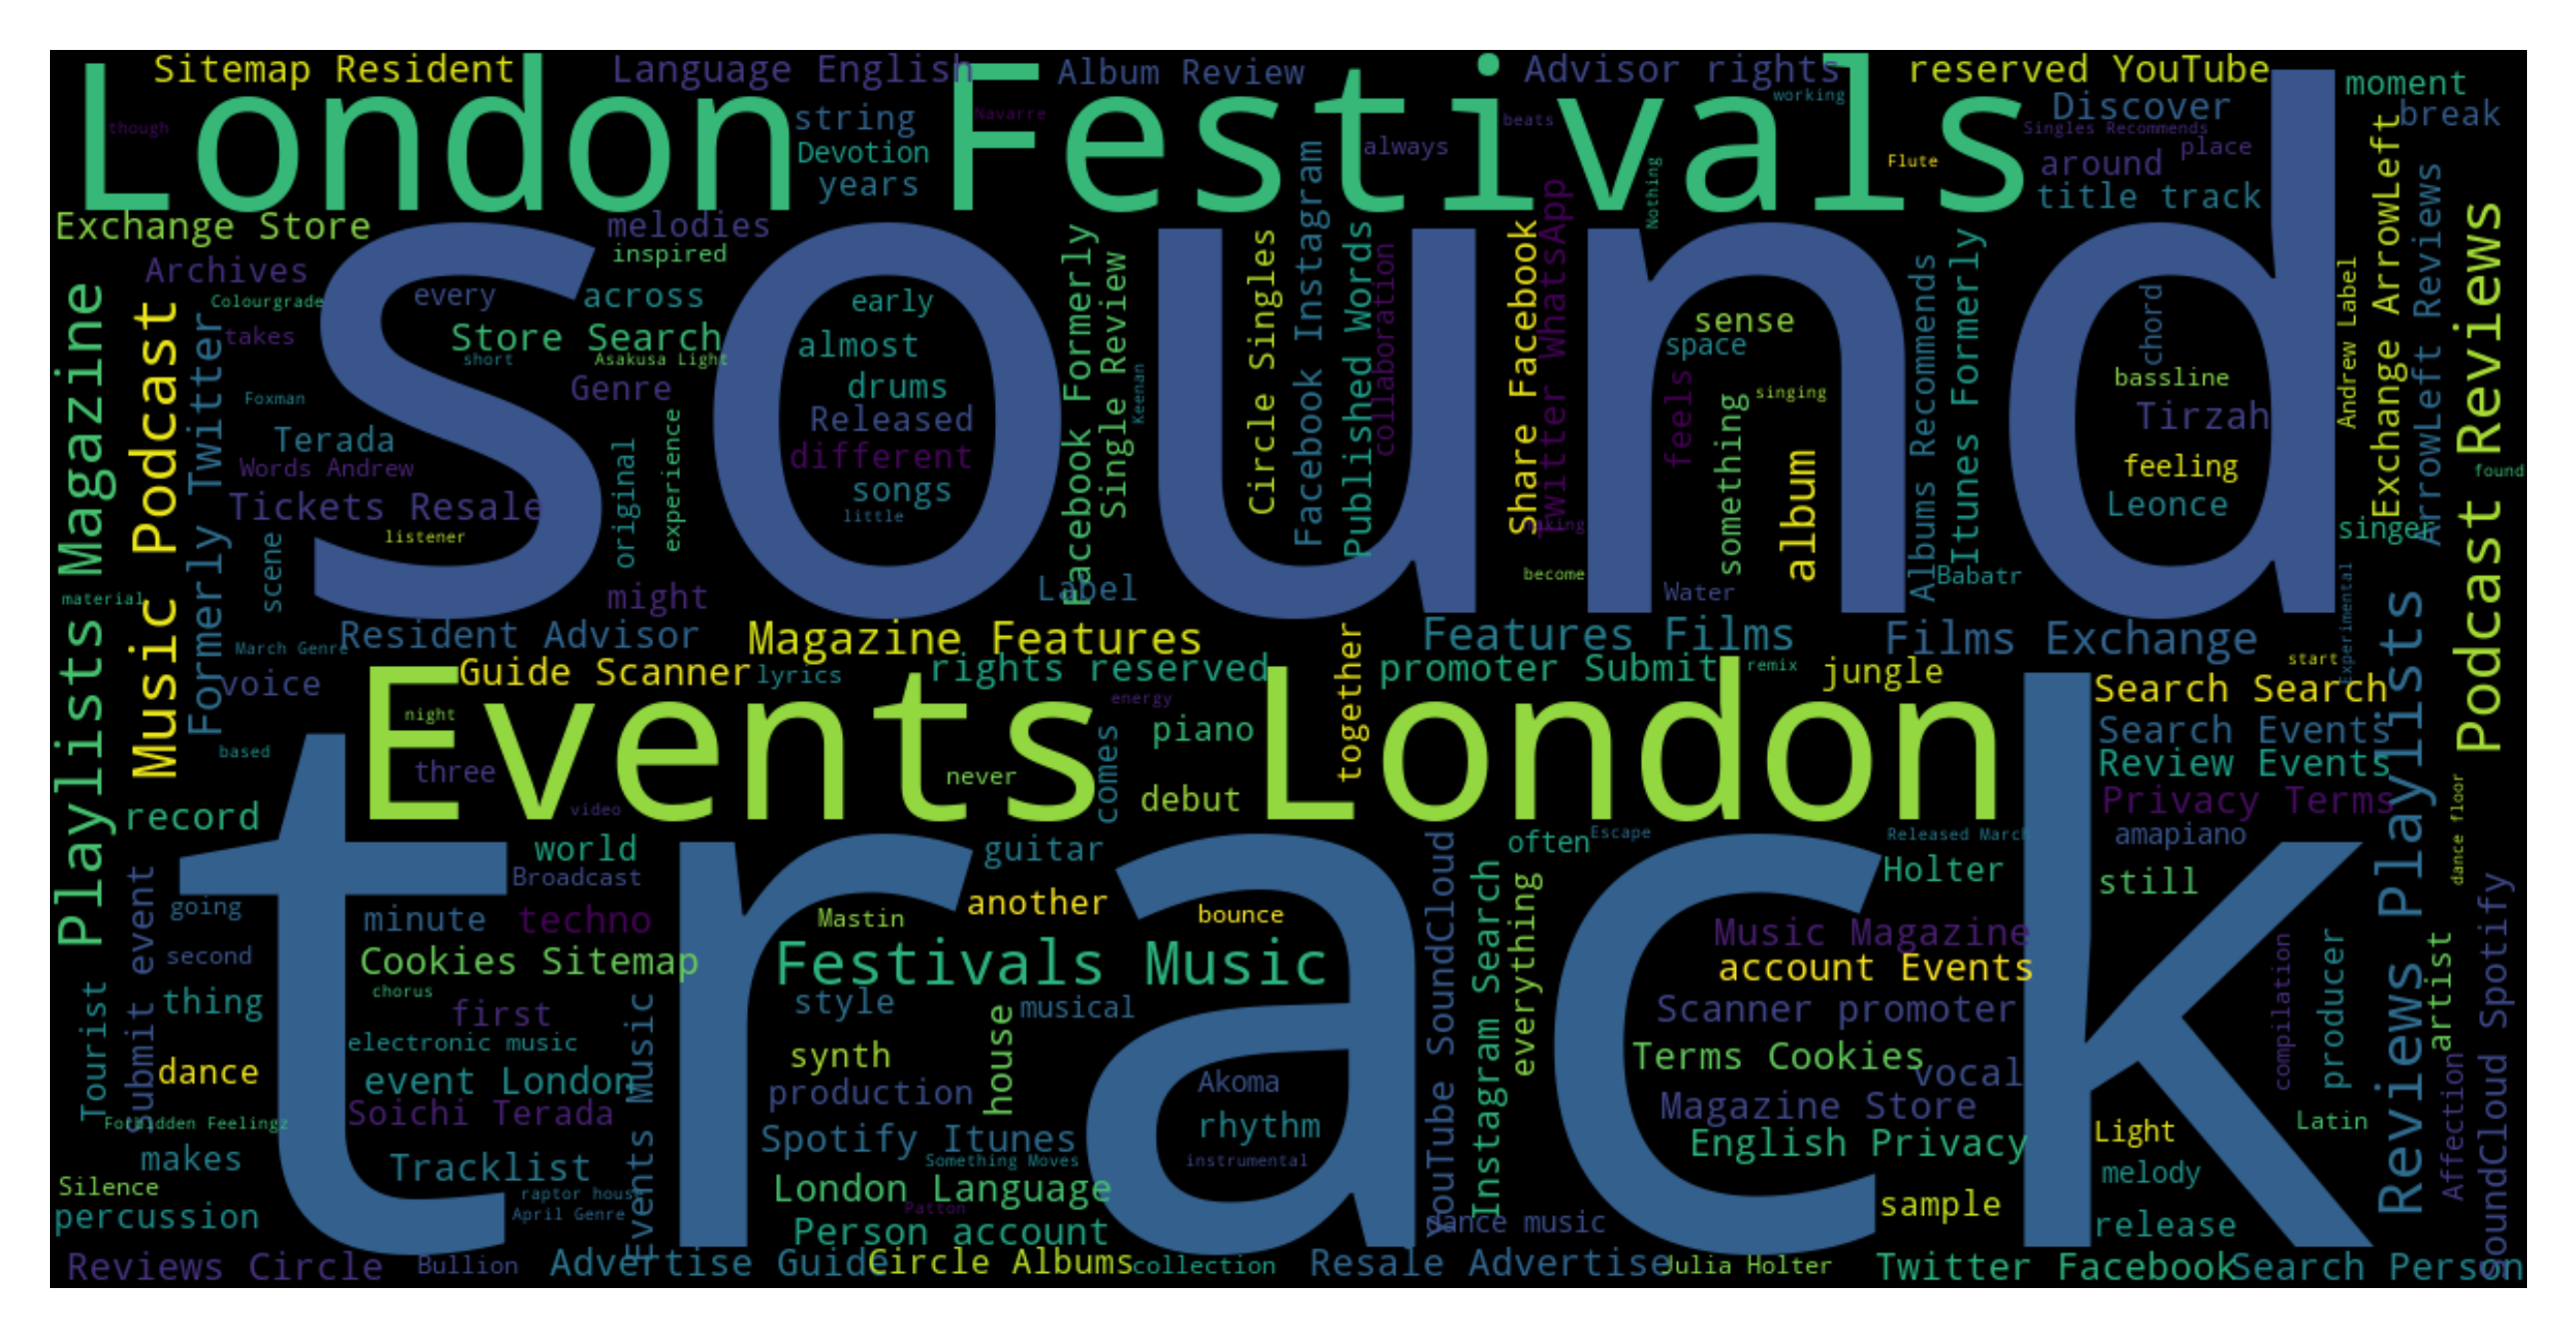

In [44]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text_list = [s.get_text(separator=' ') for s in content]
flattened = [w for words in text_list for w in words.replace('\n',' ').strip().split(' ')] # if len(w) > 5
text = ' '.join(flattened)

wordcloud = WordCloud(
                    width=600,
                    height=300,
                    min_word_length=5,
                    scale=2
                    ).generate(text)

plt.figure(dpi=500)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Good to knows:

In [ ]:
text = soup.get_text(separator=' ') # without specifying a separator it glues words together
tokens = word_tokenize(text.lower())  
lemmatizer.lemmatize(tokens[5]), nltk.pos_tag(tokens)[5], nltk.help.brown_tagset('NNS')

In [ ]:
# nested lists
nested = [[1,2,3],[1,2,4]]
[d for sublist in nested for d in sublist]

[1, 2, 3, 1, 2, 4]

In [45]:
[w for words in text_list for w in words.replace('\n',' ').strip().split(' ') if len(w) > 5]

['recommends',
 'Reviews',
 'Events',
 'Magazine',
 'Search',
 'Person',
 'account',
 'Events',
 'London',
 'Festivals',
 'Podcast',
 'Reviews',
 'Playlists',
 'Magazine',
 'Features',
 'Exchange',
 'ArrowLeft',
 'Reviews',
 'Overview',
 'Recommends',
 'Albums',
 'Singles',
 'Uppers',
 'Downers',
 'Rubinstein',
 "Rubi's",
 'rippers',
 'stunning',
 'revered',
 'techno',
 'Andrew',
 'Records',
 'Broadcast',
 'Blanket',
 'Collected',
 '2006\u200b-\u200b2009',
 'gripping',
 'outlining',
 "Broadcast's",
 'unfinished',
 'brilliance',
 'intact.',
 'Marshall',
 'Records',
 'Parker',
 'Dispatches',
 'expanded',
 'reissue',
 'greatest',
 'techno',
 'albums',
 'Andrew',
 'Ghostly',
 'International',
 'Bullion',
 'Affection',
 'Finally—the',
 'straight-up',
 'Bullion',
 'waiting',
 'Sophie',
 'McNulty',
 'Subtext',
 'Circle',
 'Unsound',
 '(\u200b\u200b\u200b굉\u200b\u200b\u200b음\u200b\u200b\u200b과',
 '울\u200b\u200b\u200b음\u200b\u200b\u200b)',
 'gorgeously',
 'grotesque,',
 'industrial-leaning',
 '

In [8]:
soup.select('a')    # = soup.find_all('a')

[<a class="Link__AnchorWrapper-sc-1huefnz-1 kQSgWi GlobalNavBarNew__GlobalNavLink-k897zf-3 hbYnGk" data-tracking-id="/" href="/"><span class="Text-sc-wks9sf-0 Link__StyledLink-sc-1huefnz-0 bulajw GlobalNavBarNew__GlobalNavLink-k897zf-3 hbYnGk" color="primary" data-tracking-id="/" font-weight="normal" href="/"><div class="Box-sc-abq4qd-0 Alignment-sc-1405w7f-0 bYddZG GlobalNavBarOld__HoverIcon-sc-1c9xj4i-0 ireZcZ" color="primary" height="50" width="50"><svg aria-label="RA logo" height="100%" viewbox="0 0 83 40" width="100%"><title>RA</title><g fill="none" fill-rule="evenodd"><path d="M0 0h24v24H0z" fill="none"></path><path d="M82.092 32.018c.556-.533.908-1.28.908-2.113 0-.802-.38-1.523-.9-2.051L58.665 4.3l-7.073 7.11 18.45 18.543h-26.14c-1.278-.038-2.29-.469-3.147-1.304l-11.73-11.788a6.828 6.828 0 00-4.689-1.888l-.017.001H10.004v-4.92h14.825c2.938.002 5.559 1.21 7.48 3.15l8.749 8.793 7.073-7.11-8.92-8.963C35.485 2.234 30.45 0 24.805 0H0v25.027h20.978v.002a4.919 4.919 0 013.486 1.48L35.9